In [5]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

In [6]:
def get_text(text_list):
    arr = []
    for t in text_list:
        arr.append(t.get_text())
    return " ".join(arr)

In [ ]:
import json

years = ['2021', '2022', '2023']
driver = webdriver.Safari()

dps_results_map = {}
dps_no_results_map = {}
for year in years:
    year_map = {}
    no_year_map = {}
    links = []
    count = -1
    page = 0
    
    # Extract the links from the page
    while count != 0:
        url = f'https://www.dps.texas.gov/news/press-releases?year={year}&field_press_release_type_value=All&page={page}'
        driver.get(url)
        wait = WebDriverWait(driver, 100)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        nsoup = soup.find(class_="views-element-container settings-tray-editable block block-views block-views-blockrecent-press-releases-block-1")
        response = nsoup.find(class_="item-list")
        if response != None:
            links.append(response.find_all('a'))
            count = len(response.find_all('a'))
        else:
            count = 0
        page = page + 1

    for ls in links:
        for link in ls:
            href = link.get('href')
            if href.startswith('/news'):
                # Navigate to the page
                url = f'https://www.dps.texas.gov{href}'
                driver.get(url)

                # Extract the relevant text
                page_soup = BeautifulSoup(driver.page_source, 'html.parser')
                texts = page_soup.find_all('p')
                text = get_text(texts).lower()

                # Store the text in a map
                if "operation lone star" in text:
                    # print(text[0:20])
                    year_map[link.get_text().lower()] = text
                else:
                    # print("none")
                    no_year_map[link.get_text().lower()] = text

    with open(f"archive/DPS/OLS/{year}.json", "w") as outfile:
        # write the dictionary to the file as JSON
        json.dump(year_map, outfile)

    with open(f"archive/DPS/noOLS/{year}.json", "w") as outfile:
        # write the dictionary to the file as JSON
        json.dump(no_year_map, outfile)
    
    dps_results_map[year] = year_map
    dps_no_results_map[year] = no_year_map
            
driver.quit()  

Now lets look at how many articles we obtained

In [8]:
total = 0
for year in dps_results_map:
    total = total + len(dps_results_map[year])
print(total, "total articles containing \"Operation Lone Star\"")

total = 0
for year in dps_no_results_map:
    total = total + len(dps_no_results_map[year])
print(total, "total articles not containing \"Operation Lone Star\"")

37 total articles containing "Operation Lone Star"
220 total articles not containing "Operation Lone Star"


Here is the code for reading the article information from the JSON files, so we can avoid using the web driver every time

In [7]:
import json

years = ['2021', '2022', '2023']

dps_results_map = {}
dps_no_results_map = {}
for year in years:
    
    f = open(f'archive/DPS/OLS/{year}.json')
    data = json.load(f)
    dps_results_map[year] = data

    f = open(f'archive/DPS/noOLS/{year}.json')
    data = json.load(f)
    dps_no_results_map[year] = data
    

Here I saved all the articles as individual text files

TODO: include the dates in all of them

In [33]:
for year in dps_results_map:
    count = 0
    for key in dps_results_map[year]:
        with open(f"articles_txt/DPS/{year}/{count}.txt", 'w+') as outfile:
            outfile.write(f'{key}\n\n{dps_results_map[year][key]}')
        count = count + 1

## Analysis of DPS articles

In [9]:
import nltk
from nltk import FreqDist

I will convert the maps to numpy arrays for easy handling

In [10]:
import numpy as np

years = ['2021', '2022', '2023']

dps_results_dict = {}
for year in years:
    # print(results_map[year])
    text_year = " ".join(dps_results_map[year].values())
    dps_results_dict[f'{year}'] = text_year
        
# print(len(all_results_dict))
# print(all_results_dict.items())

dtype = np.dtype([
    ('id', int),
    ('date', object),
    ('text', object),
])

data_list = [(i, k, "".join(list(v))) for i, (k, v) in enumerate(dps_results_dict.items())]

dps_results_np = np.array(data_list, dtype=dtype)

print(dps_results_np[2])

(2, '2023', '')


In [11]:
dps_results_np['date']

array(['2021', '2022', '2023'], dtype=object)

In [17]:
def rep(s, words):
    for key in words:
        for value in words[key]:
            s = s.replace(value, key)
    return s

In [20]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

# create list of stop words and add additional words
stop_words = set(stopwords.words('english'))
new_words = {'texas', 'operation', 'lone', 'star', 'us', 'ols', 'said', 'state', 'pdf', 'adobe', 'reader', 'one',
            'two', 'u'}
stop_words = stop_words.union(new_words)

# define tokenizer and patters for phrase matching
tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
pattern = [r'\bopen\sborder\b']

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'request': ['requests']
}

dps_freqs = {}
for _,d,t in dps_results_np:
    
    # replace similar words and phrases together
    t = rep(t, words_to_replace)
    
    # tokenize the articles and perform phrase matching 
    words = tokenizer.tokenize(t)
    new_tokens = []
    for i in range(len(words)):
        if i < len(words)-1 and re.match(pattern[0], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        else:
            new_tokens.append(words[i])

    # filter out stop words and save list of frequencies
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    fdist = FreqDist(filtered_tokens)
    dps_freqs[d] = fdist
    
for k, v in dps_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

2021 :
dps: 323
border: 81
visit: 49
contact: 48
page: 48
request: 48
criminal: 42
trooper: 42
tmd: 41
media: 41

2022 :
dps: 165
patrol: 45
trooper: 34
highway: 32
visit: 30
page: 30
contact: 26
request: 26
public: 25
special: 25

2023 :



In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

because 2023 did not have any articles with our key term, I will not include it in our analysis

<AxesSubplot: >

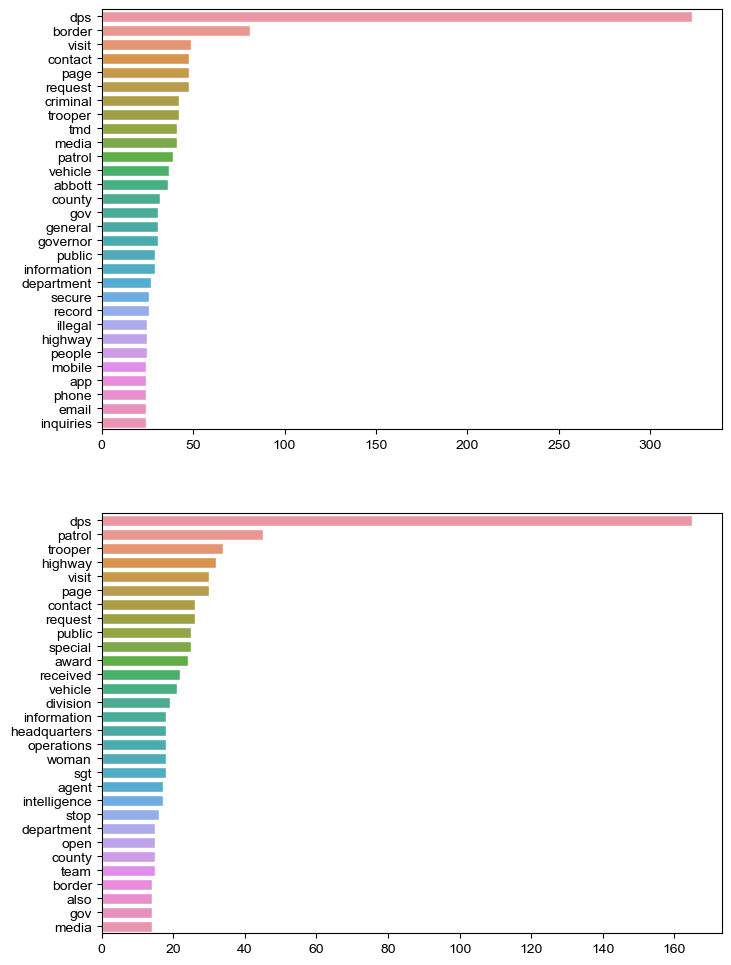

In [22]:
dps_top_words_2021 = dps_freqs['2021'].most_common(30)
dps_top_words_2022 = dps_freqs['2022'].most_common(30)


# Create a bar plot of the most common words
fig, axes = plt.subplots(2,1,figsize=(8,12))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in dps_top_words_2021], 
            y=[w[0] for w in dps_top_words_2021])

sns.barplot(ax = axes[1], 
            x=[w[1] for w in dps_top_words_2022], 
            y=[w[0] for w in dps_top_words_2022])

now lets analyze the words overall for the DPS articles

In [24]:
dps_all_text = " ".join(dps_results_np['text'])


dps_all_text = rep(dps_all_text, words_to_replace)

# tokenize the articles and perform phrase matching 
dps_words = tokenizer.tokenize(dps_all_text)
new_tokens = []
for i in range(len(dps_words)):
    if i < len(dps_words)-2 and re.match(pattern[0], dps_words[i] + " " + dps_words[i+1]+ " " + dps_words[i+2]):
        new_tokens.append(dps_words[i] + " " + dps_words[i+1] + " " + dps_words[i+2])
    else:
        new_tokens.append(dps_words[i])

dps_filtered_tokens = [token for token in new_tokens if token not in stop_words]
dps_fdist = FreqDist(dps_filtered_tokens)


for word, frequency in dps_fdist.most_common(10):
    print(f"{word}: {frequency}")

dps: 488
border: 95
patrol: 84
visit: 79
page: 78
trooper: 76
contact: 74
request: 74
vehicle: 58
highway: 57


<AxesSubplot: >

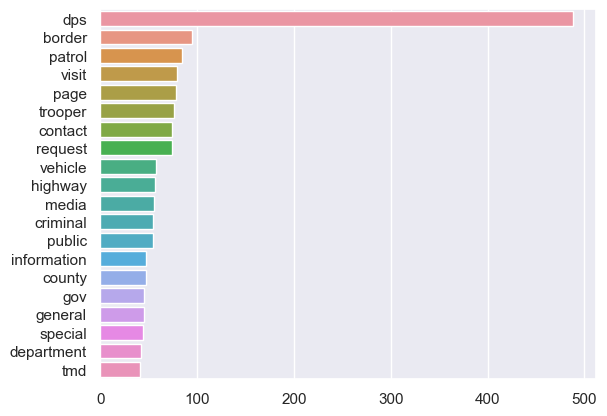

In [25]:
dps_top_words = dps_fdist.most_common(20)

# Create a bar plot of the most common words
sns.set(style="darkgrid")
sns.barplot(x=[w[1] for w in dps_top_words], y=[w[0] for w in dps_top_words])

## Word Cloud

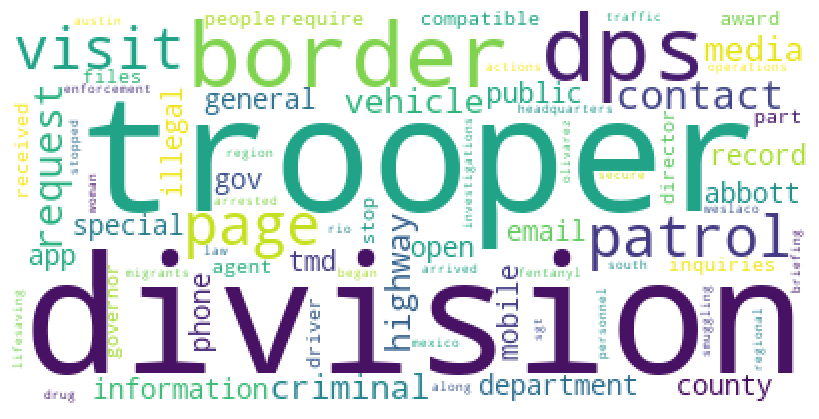

In [26]:
from wordcloud import WordCloud

dps_top_words = dps_fdist.most_common(75)
text = ""
for word, _ in dps_top_words:
    text += word + " "

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [35]:
text = ""
for word, _ in dps_top_words:
    text += word + "\n"
with open(f"Top_75/Dps_top75.txt", 'w+') as outfile:
    outfile.write(text)

## Line Graph

In [ ]:
# Get the unique set of words from all the top words
unique_words = set()
for words in month_freqs.values():
    w = words.most_common(4)
    vals = [word for word, _ in w]
    unique_words.update(vals)
    
# create dictionary for words
word_counts = {word: [0]*26 for word in unique_words}
for i, month in enumerate(month_freqs.values()):
    w = month.most_common(4)
    for word, num in w:
        word_counts[word][i] = num

In [ ]:
# Create a line graph of word counts over time
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(range(len(month_freqs))[::2], list(month_freqs.keys())[::2])
plt.xticks(rotation=45)
for word in word_counts.keys():
    ax.plot(month_freqs.keys(), word_counts[word], label=word)
    if word_counts[word][-1] != 0:
        ax.text(len(month_freqs.keys())-1, word_counts[word][-1], word, ha='left', va='center')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Word count')
ax.set_title('Most popular words over time')
plt.show()